In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from pathlib import Path
from torch.utils.data import DataLoader

from torchfitter.trainer import Trainer
from torchfitter.utils import DataWrapper
from torchfitter.regularization import L1Regularization

from sklearn.model_selection import train_test_split

torch.manual_seed(0)
np.random.seed(0)

In [3]:
DATA_PATH = Path(os.path.abspath('')).parent / "tests/data"

In [4]:
X = np.load(DATA_PATH / "features.npy")
y = np.load(DATA_PATH / "labels.npy")

y = y.reshape(-1,1)

In [5]:
# simplest case of cross-validation
X_train, X_val, y_train, y_val = train_test_split(
    X, 
    y, 
    test_size=0.33, 
    random_state=42
)

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
model = nn.Linear(in_features=1, out_features=1)
model.to(device)

regularizer = L1Regularization(regularization_rate=0.01, biases=False)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [8]:
from torchfitter.callbacks import LoggerCallback, EarlyStopping, LearningRateScheduler

In [9]:
callbacks = [
    LoggerCallback(update_step=100),
    EarlyStopping(patience=100, load_best=False, path='checkpoint.pt'),
    LearningRateScheduler(
        scheduler=optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.9)
    )
]

In [10]:
trainer = Trainer(
    model=model, 
    criterion=criterion,
    optimizer=optimizer, 
    regularizer=regularizer,
    device=device,
    callbacks=callbacks
)

In [11]:
# wrap data in Dataset
train_wrapper = DataWrapper(
    X_train, 
    y_train, 
    dtype_X='float', 
    dtype_y='float'
)
val_wrapper = DataWrapper(
    X_val,
    y_val,
    dtype_X='float',
    dtype_y='float'
)

# torch Loaders
train_loader = DataLoader(train_wrapper, batch_size=128, pin_memory=True)
val_loader = DataLoader(val_wrapper, batch_size=128, pin_memory=True)

----

In [12]:
from torchfitter.manager import Manager

In [13]:
# define random seeds
seeds = (5, 0, 10)

manager = Manager(
    trainer=trainer,
    seeds=seeds
)

In [14]:
manager.run_experiments(train_loader, val_loader, 1000)

  0%|          | 0/999 | ? epoch/s, ramaining_time: ? s

INFO:root:Starting training process on cuda
INFO:root:End of training. Total time: 43.58510 seconds
INFO:root:Ending training on seed 5


  0%|          | 0/999 | ? epoch/s, ramaining_time: ? s

INFO:root:Starting training process on cuda
INFO:root:End of training. Total time: 43.62520 seconds
INFO:root:Ending training on seed 0


  0%|          | 0/999 | ? epoch/s, ramaining_time: ? s

INFO:root:Starting training process on cuda
INFO:root:End of training. Total time: 44.10919 seconds
INFO:root:Ending training on seed 10


In [15]:
from torchfitter.io import load_pickle

In [16]:
experiments = {}

for seed in seeds:
    mod = torch.load(f'experiment_{seed}/model_parameters.pt')
    op = torch.load(f'experiment_{seed}/optim_parameters.pt')
    hist = load_pickle(f'experiment_{seed}/history.pkl')
    
    experiments[seed] = {}
    
    experiments[seed]['model'] = mod
    experiments[seed]['optimizer'] = op
    experiments[seed]['history'] = hist

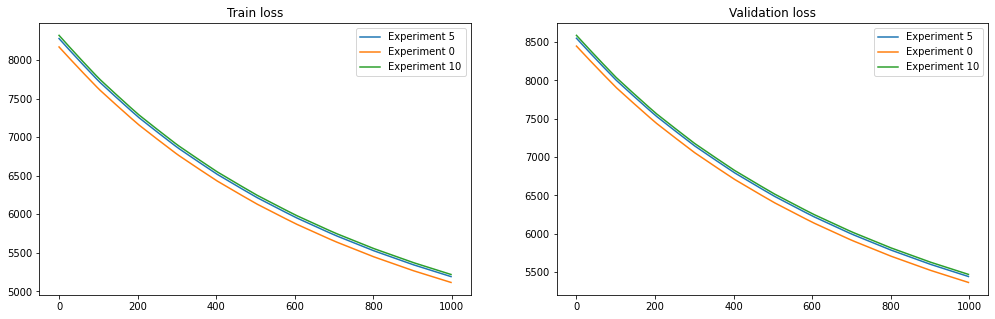

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(17, 5))

for key in experiments.keys():
    hist = experiments[key]['history']
    
    ax[0].plot(hist['train_loss'], label=f'Experiment {key}')
    ax[0].set_title('Train loss')
    ax[0].legend()
    
    ax[1].plot(hist['validation_loss'], label=f'Experiment {key}')
    ax[1].set_title('Validation loss')
    ax[1].legend()